This is the second model. This time, instead of fitting the setting of the RoboCup Challenge, this model seeks to generalize to all datasets.

In [1]:
# Import Libraries
from random import random
import numpy as np
import scipy.misc
import cv2
from math import floor, exp, pi, cos, sin
from skimage.color import rgba2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D
import keras
import os
from skimage import img_as_ubyte, img_as_float
from scipy.ndimage import rotate

/home/nlu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nlu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nlu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nlu/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:522: FutureWarnin

In [2]:
# Load pictures of hazmat labels
pics = np.load("pics.npy")

In [ ]:
# Get a random batch of background images generated by GenerateBackgrounds, of shape (64, 150, 150, 3)
bgs_path = listdir("bgs")
num_bg = len(bgs_path)
def get_bg():
    random_index = floor(num_bg*random())
    path = "bgs/{}".format(bgs_path[random_index])
    return img_as_float(np.load(path))

In [3]:
# Rotates a picture randomly
def rand_rotate(pic): 
    angle = random()*360
    return rotate(pic, angle, reshape=False, mode='constant', cval=0.)

In [4]:
# Adds noise to a picture
def add_noise(img, scale):
    new_img = np.random.normal(img, scale)
    new_img = np.clip(new_img, 0, 1)
    return new_img

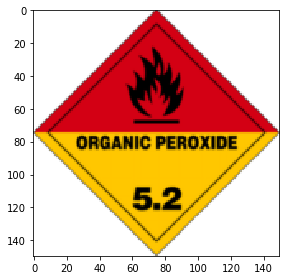

In [19]:
imshow(pics[50])

In [10]:
def hsv_aug_rgb(img):
    return np.clip(img*(0.75+0.5*random()) + np.random.normal(0, 0.12, (1,1,3)), 0, 1) 

In [11]:
# The code below generates a random shadow on an image
# Generates random points, and uses an inverse matrix to calculate the corresponding 5th degree polynomial, which will serve as the shadow

# Sigmoid function with a varied rate
def sigmoid(x, rate):
    return 1/(1+np.exp(-rate*x))

# Create Mapping A_inv from a set of points to a 5th degree polynomial
A = np.array([4,3,2,1,0])
B = np.array([0,38,75,113,150]).reshape((5,1))
C = np.zeros((5, 1))
P = C + A
A = np.power(B,P)
A_inv = np.linalg.inv(A)

# Used later to apply shadow
I = np.linspace(0, 149, 150, dtype=np.float64).reshape(150,1,1)
J = np.linspace(0, 149, 150, dtype=np.float64).reshape(1,150,1)

def apply_shadow(img):
    shadow = 0.5*random() # How dark the shadow is
    rate = 0.1 + 0.3*random() # How sharp the shadow is

    # Random points chosen where the shadow passes through
    X = np.random.normal(75, 25, (5,))
    # Create polynomial p of the shadow
    p = np.poly1d(np.dot(A_inv, X))
    

    # Apply the shadow in a random direction
    _ = random()
    if _ < 0.25:
        multiplier = 1 - shadow * sigmoid(p(I) - J, rate)
    elif _ < 0.5:
        multiplier = 1 - shadow * sigmoid(J - p(I), rate)
    elif _ < 0.75:
        multiplier = 1 - shadow * sigmoid(p(J) - I, rate) 
    else:
        multiplier = 1 - shadow * sigmoid(I - p(J), rate)
    return img * multiplier

In [12]:
# Distorts the image by changing its camera angle
# This is achieved through generating a random orthonormal basis, finding a random rotation, and then using cv2's findHomography 
# function to distort the image.

from scipy.ndimage import affine_transform

# Returns a matrix that rotates by angle beta
def T(beta):
    T = [
        [1,0,0],
        [0,cos(beta),-sin(beta)],
        [0,sin(beta),cos(beta)]
    ]
    return np.array(T)

# Define original coordinates, coordinates that will be transformed
S_coord = [
        [1,1,0,0],
        [1,0,1,0],
        [0,0,0,0]
    ]
S_coord = np.array(S_coord)
S_img = np.transpose(75*S_coord[:2,:]+75)


#Changes the camera angle of a picture by a random degree
def camera_angle(img):
    
    angle = 5*pi/12*random()  # Random camera angle
    
    # Generate random orthonormal matrix Q using QR decomposition on a random matrix
    H = np.random.randn(3, 3)
    Q, _ = np.linalg.qr(H)
    
    # Compute Q*T*Q_inv, the transformation matrix T in orthonormal basis Q
    t = T(angle)
    trans = np.dot(np.dot(Q, t), np.transpose(Q))
    
    # Compute S_coord's mapping S_new
    S_new = np.dot(trans, S_coord)
    S_new = np.transpose(75*S_new[:2,:]+75)

    # Find the homography from S to S_new, and apply the matrix M to the image
    M, mask = cv2.findHomography(S_img, S_new)
    img_dst = cv2.warpPerspective(img, M, None)
    
    return img_dst

In [14]:
def to_128(img):
    rand_x = floor(random()*22)
    rand_y = floor(random()*22)
    return img[rand_x:rand_x+128, rand_y:rand_y+128]

In [15]:
def reduce_size(img):
    size_down = int(40*random())
    before = int(size_down/2)
    new_size = 150 - size_down
    new_img = resize(img, (new_size, new_size))
    blank = np.zeros((150,150,4))
    blank[before: before + new_size, before: before + new_size] = new_img
    return blank

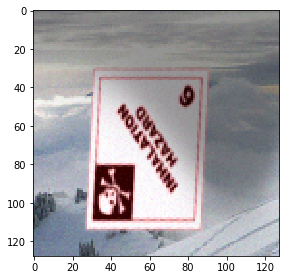

In [88]:
def gen_im(l):
    # 70% chance to get a random image as a background
    # 30% chance to get a random solid color as a background
    if(random()<0.7):
        bg = get_bg[int(random()*64)]
    else: 
        bg = np.random.random(size = (1,1,3)) + np.zeros((150,150,3))
    pic = camera_angle(rand_rotate(reduce_size(pics[l])))    # Random size of picture, then randomly rotates images, then changes camera angle
    alpha = pic[:,:,3:4]  # Save alpha channel
    pic = rgba2rgb(pic)  
    pic = hsv_aug_rgb(pic) # HSV augmentation
    combined = np.multiply(bg, 1-alpha)+np.multiply(pic, alpha) # combine alpha channel
    combined = add_noise(combined, 0.02) # Gaussian noise
    combined = apply_shadow(combined) # Apply a random shadow
    combined = to_128(combined) # Reduce to 128 by 128, randomly places the 
    return combined

imshow(gen_im(52))

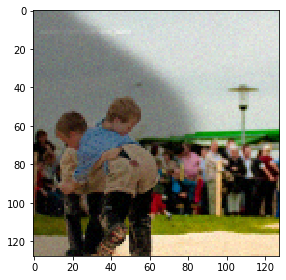

In [36]:
# Generates an image with no hazmat label
def gen_no_label():
    if random()<0.7:
        bg = get_bg[int(random()*64)]
        bg = apply_shadow(bg)
        bg = add_noise(bg, 0.02)
        return to_128(bg)
    else:
        bg = np.random.random(size = (1,1,3)) + np.zeros((128,128,3))
        bg = add_noise(bg, 0.02)
        return bg
    
imshow(gen_no_label())

In [14]:
# Modified from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
# This DataGenerator class generates batches as the model trains
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, fake_size, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.fake_size = fake_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(fake_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate data
        X, y = self.__data_generation(1)

        return X, y

    def on_epoch_end(self):
        pass
    
    def __data_generation(self, num):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i in range(self.batch_size):
            
            # Get random label
            l = floor(random()*63)

            # Store sample
            if l == 62:
                X[i,] = gen_no_label()
            else:
                X[i,] = gen_im(l)

            # Store class
            y[i] = l
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [20]:
# Define the model. This is a model inspired by the YOLO Algorithm https://arxiv.org/abs/1506.02640. 
# I use the same 1x1 channels for efficiency
model = Sequential()
model.add(Conv2D(64, kernel_size=7, strides=2, activation='relu', input_shape=(128,128,3)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(128, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(128, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(512, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(256, kernel_size=3, strides=1, activation='relu'))
model.add(Conv2D(512, kernel_size=1, strides=1, activation='relu'))
model.add(Conv2D(512, kernel_size=3, strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(1024, kernel_size=3, strides=1, activation='relu'))
model.add(Flatten())
model.add(Dense(63, activation='softmax'))

In [21]:
# Define optimizer, loss
# The adam optimizer is a very efficient optimizer: https://arxiv.org/abs/1412.6980
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# Define training parameters
params = {'dim': (128,128),
          'batch_size': 64,
          'n_classes': 63,
          'n_channels': 3
         }

# Dataset size
fake_size = 100000

# Generator for training
training_generator = DataGenerator(fake_size, **params)
validation_generator = DataGenerator(fake_size, **params)

In [23]:
# Prevent Memory Hog
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))
# Print available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16919045002624781260
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7342414234
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17619038438052810374
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [24]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=1
                   )

Epoch 1/1
1562/1562 [==============================] - 1684s 1s/step - loss: 2.6740 - acc: 0.2226


In [25]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=2
                   )

Epoch 1/2
1562/1562 [==============================] - 1639s 1s/step - loss: 1.8592 - acc: 0.4128
Epoch 2/2
1562/1562 [==============================] - 1583s 1s/step - loss: 1.3341 - acc: 0.5310


In [26]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=2
                   )

Epoch 1/2
1562/1562 [==============================] - 1583s 1s/step - loss: 0.9329 - acc: 0.6482
Epoch 2/2
1562/1562 [==============================] - 1587s 1s/step - loss: 0.7073 - acc: 0.7386


In [27]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=2
                   )

Epoch 1/2
1562/1562 [==============================] - 1573s 1s/step - loss: 0.5393 - acc: 0.8097
Epoch 2/2
1562/1562 [==============================] - 1651s 1s/step - loss: 0.4343 - acc: 0.8491


In [29]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=2
         
                   )

Epoch 1/2
1562/1562 [==============================] - 1673s 1s/step - loss: 0.3828 - acc: 0.8662
Epoch 2/2
1562/1562 [==============================] - 1652s 1s/step - loss: 0.3535 - acc: 0.8766


In [30]:
model.save("one_pic7_1")

In [ ]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    use_multiprocessing=False,
                    epochs=1
         
                   )

Epoch 1/1
